In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('csv/K15T_K16_K17.csv')

In [2]:
# Replace spaces with underscores in column headings
df.columns = df.columns.str.replace(' ', '_')

ord_list = ['Age_Group']
cat_list = [col for col in df.columns if (df[col].dtype == 'object') and col not in ord_list]
num_list = [col for col in df.columns if df[col].dtype == 'int' or df[col].dtype == 'float' and col not in ord_list]

for col in ord_list:
    print(f'======== {col} =========')
    print(df[col].unique())

for col in cat_list:
    print(f'======== {col} =========')
    print(df[col].unique())

======== Age_Group =========
['15 - 29' '30 - 39' '40 - 49' '50 & Over']
======== Gender =========
['Male' 'Female']
======== Type =========
['Long-term' 'Short-term']
======== Occupation =========
['Associate Professionals & Technicians'
 'Managers & Administrators (Including Working Proprietors)'
 'Professionals' 'Cleaners, Labourers & Related Workers'
 'Clerical Support Workers' 'Craftsmen & Related Trades Workers' 'Others'
 'Plant & Machine Operators & Assemblers' 'Service & Sales Workers']
======== Pmet_Status =========
['PMETs' 'Non-PMETs']


Optional enhancement: You could test both approaches—ordinal vs. one-hot— for the Age-Group and compare model fit (e.g., adjusted R², AIC/BIC).     

However, if the age group is ordinal, mapping it to 1–4 is fine if the spacing between categories is meaningful (e.g., 15–24, 25–34, etc.).

In [3]:
# Handle ordinal list
Ord_dict_list = {}
for col in ord_list:
    if col in df.columns:
        Ord_elements = df[col].unique()
        Counter = 0
        mapping = {}
        for element in Ord_elements:
            mapping[element] = Counter
            Counter += 1 
        # print(mapping)
        Ord_dict_list[col] = mapping

print(Ord_dict_list)

# Encode for ordinal list
df_encoded = df.copy()
for item in Ord_dict_list:
    # print(Ord_dict_list[item])
    if item in df.columns: 
        df_encoded[f'{item}_Encoded'] = df[item].map(Ord_dict_list[item])
        df_encoded.drop(item, axis = 1, inplace= True)
        df_encoded.rename({f'{item}_Encoded' : item}, axis= 1, inplace=True)
        # print(df[f'{item}_Encoded'])

df_encoded.head()


{'Age_Group': {'15 - 29': 0, '30 - 39': 1, '40 - 49': 2, '50 & Over': 3}}


,Gender,Type,Count_(Thousands),Year,Occupation,Pmet_Status,Age_Group
0,Male,Long-term,0.286364,2014,Associate Professionals & Technicians,PMETs,0
1,Male,Short-term,1.317603,2014,Associate Professionals & Technicians,PMETs,0
2,Female,Long-term,0.000000,2014,Associate Professionals & Technicians,PMETs,0
3,Female,Short-term,1.629557,2014,Associate Professionals & Technicians,PMETs,0
4,Male,Long-term,0.182998,2014,Managers & Administrators (Including Working P...,PMETs,0


In [4]:
# Replace spaces with underscores in categorical columns
for col in cat_list:
    df_encoded[col] = df_encoded [col].str.replace(' ', '_')

# One-hot encoding for cat_list less occupation because do not want to drop first of occupation
cat_list_less_occupation = [col for col in cat_list if col != 'Occupation']
df_encoded = pd.get_dummies(df_encoded, columns=cat_list_less_occupation, drop_first=True)

# Display the encoded dataframe and properties
# print(df_encoded.head())
print(df_encoded.info())
print(df_encoded.shape)
print(df_encoded.isnull().sum().any())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count_(Thousands)  1584 non-null   float64
 1   Year               1584 non-null   int64  
 2   Occupation         1584 non-null   object 
 3   Age_Group          1584 non-null   int64  
 4   Gender_Male        1584 non-null   bool   
 5   Type_Short-term    1584 non-null   bool   
 6   Pmet_Status_PMETs  1584 non-null   bool   
dtypes: bool(3), float64(1), int64(2), object(1)
memory usage: 54.3+ KB
None
(1584, 7)
False


In [5]:
# encode occupation manually to drop last of occupation that is "others"
dummies = pd.get_dummies(df_encoded['Occupation'])
dummies.drop('Others', axis=1,inplace = True)
dummies

df_encoded = pd.concat([df_encoded, dummies], axis=1)
df_encoded.drop(['Occupation'], axis=1, inplace=True)
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 14 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Count_(Thousands)                                          1584 non-null   float64
 1   Year                                                       1584 non-null   int64  
 2   Age_Group                                                  1584 non-null   int64  
 3   Gender_Male                                                1584 non-null   bool   
 4   Type_Short-term                                            1584 non-null   bool   
 5   Pmet_Status_PMETs                                          1584 non-null   bool   
 6   Associate_Professionals_&_Technicians                      1584 non-null   bool   
 7   Cleaners,_Labourers_&_Related_Workers                      1584 non-null   bool   
 8   Clerical

In [6]:
# to handle fixed time effects
df_encoded = pd.get_dummies(df_encoded, columns=['Year'], drop_first=True)

# Convert all Boolean columns (True/False) to 1/0
for col in df_encoded.columns:
    if col not in num_list and col not in ord_list and col not in cat_list: 
        df_encoded[col] = df_encoded[col].astype(int)

print(df_encoded.info())
print(df_encoded.shape)
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 23 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Count_(Thousands)                                          1584 non-null   float64
 1   Age_Group                                                  1584 non-null   int64  
 2   Gender_Male                                                1584 non-null   int32  
 3   Type_Short-term                                            1584 non-null   int32  
 4   Pmet_Status_PMETs                                          1584 non-null   int32  
 5   Associate_Professionals_&_Technicians                      1584 non-null   int32  
 6   Cleaners,_Labourers_&_Related_Workers                      1584 non-null   int32  
 7   Clerical_Support_Workers                                   1584 non-null   int32  
 8   Craftsme

,Count_(Thousands),Age_Group,Gender_Male,Type_Short-term,Pmet_Status_PMETs,Associate_Professionals_&_Technicians,"Cleaners,_Labourers_&_Related_Workers",Clerical_Support_Workers,Craftsmen_&_Related_Trades_Workers,Managers_&_Administrators_(Including_Working_Proprietors),...,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024
0,0.286364,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.317603,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.629557,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.182998,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import statsmodels.api as sm

def pooled_linear_regression_homoskedasticity(df, y_label):
    # Define features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label]

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit()

    # Print the full summary of regression results
    return model.summary()

def pooled_linear_regression_heteroskedasticity(df, y_label):
    # Define features and target
    X = df.drop(y_label, axis=1)
    y = df[y_label]

    # Add constant term for intercept
    X = sm.add_constant(X)

    # Fit the OLS regression model
    model = sm.OLS(y, X).fit(cov_type='HC3')

    # Print the full summary of regression results
    return model.summary()

In [8]:
# First run 
pooled_linear_regression_homoskedasticity(df_encoded, 'Count_(Thousands)')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Count_(Thousands)   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     61.88
Date:                Fri, 12 Sep 2025   Prob (F-statistic):          7.38e-188
Time:                        23:20:20   Log-Likelihood:                -1300.7
No. Observations:                1584   AIC:                             2645.
Df Residuals:                    1562   BIC:                             2763.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                        -0.4959      0.066     -7.462      0.000      -0.626      -0.366
Age_Group                                                     0.0627      0.012      5.039      0.000       0.038       0.087
Gender_Male                                                   0.0393      0.028      1.411      0.159      -0.015       0.094
Type_Short-term                                               0.7035      0.028     25.277      0.000       0.649       0.758
Pmet_Status_PMETs                                             0.6021      0.036     16.653      0.000       0.531       0.673
Associate_Professionals_&_Technicians                         0.3365      0.036      9.307      0.000       0.266       0.407
Cleaners,_Labourers_&_Related_Workers                         0.4078      0.059      6.907      0.000       0.292       0.524
Clerical_Support_Workers                                      0.8737      0.059     14.798      0.000       0.758       0.990
Craftsmen_&_Related_Trades_Workers                            0.1209      0.059      2.047      0.041       0.005       0.237
Managers_&_Administrators_(Including_Working_Proprietors)    -0.0260      0.036     -0.719      0.472      -0.097       0.045
Plant_&_Machine_Operators_&_Assemblers                        0.2754      0.059      4.665      0.000       0.160       0.391
Professionals                                                 0.2916      0.036      8.065      0.000       0.221       0.363
Service_&_Sales_Workers                                       0.8561      0.059     14.499      0.000       0.740       0.972
Year_2015                                                     0.0062      0.065      0.096      0.924      -0.122       0.134
Year_2016                                                     0.0486      0.065      0.745      0.457      -0.079       0.177
Year_2017                                                     0.0563      0.065      0.862      0.389      -0.072       0.184
Year_2018                                                     0.0188      0.065      0.287      0.774      -0.109       0.147
Year_2019                                                     0.0715      0.065      1.096      0.273      -0.057       0.200
Year_2020                                                     0.2361      0.065      3.617      0.000       0.108       0.364
Year_2021                                                     0.1535      0.065      2.351      0.019       0.025       0.282
Year_2022                                                     0.0285      0.065      0.436      0.663      -0.100       0.157
Year_2023                                                  

#### tackling multicollinearity

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# step 1: drop PMET_Status (obvious feature); re-run and check for "strong multicollinearity problems" msg
if 'Pmet_Status_PMETs' in df_encoded.columns: 
    df_encoded.drop('Pmet_Status_PMETs', axis =1 , inplace= True)
df_encoded.columns
summary = pooled_linear_regression_homoskedasticity(df_encoded, 'Count_(Thousands)')
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Count_(Thousands)   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     61.88
Date:                Fri, 12 Sep 2025   Prob (F-statistic):          7.38e-188
Time:                        23:20:20   Log-Likelihood:                -1300.7
No. Observations:                1584   AIC:                             2645.
Df Residuals:                    1562   BIC:                             2763.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
const                                                        -0.4959      0.066     -7.462      0.000      -0.626      -0.366
Age_Group                                                     0.0627      0.012      5.039      0.000       0.038       0.087
Gender_Male                                                   0.0393      0.028      1.411      0.159      -0.015       0.094
Type_Short-term                                               0.7035      0.028     25.277      0.000       0.649       0.758
Associate_Professionals_&_Technicians                         0.9386      0.059     15.897      0.000       0.823       1.054
Cleaners,_Labourers_&_Related_Workers                         0.4078      0.059      6.907      0.000       0.292       0.524
Clerical_Support_Workers                                      0.8737      0.059     14.798      0.000       0.758       0.990
Craftsmen_&_Related_Trades_Workers                            0.1209      0.059      2.047      0.041       0.005       0.237
Managers_&_Administrators_(Including_Working_Proprietors)     0.5761      0.059      9.757      0.000       0.460       0.692
Plant_&_Machine_Operators_&_Assemblers                        0.2754      0.059      4.665      0.000       0.160       0.391
Professionals                                                 0.8937      0.059     15.137      0.000       0.778       1.010
Service_&_Sales_Workers                                       0.8561      0.059     14.499      0.000       0.740       0.972
Year_2015                                                     0.0062      0.065      0.096      0.924      -0.122       0.134
Year_2016                                                     0.0486      0.065      0.745      0.457      -0.079       0.177
Year_2017                                                     0.0563      0.065      0.862      0.389      -0.072       0.184
Year_2018                                                     0.0188      0.065      0.287      0.774      -0.109       0.147
Year_2019                                                     0.0715      0.065      1.096      0.273      -0.057       0.200
Year_2020                                                     0.2361      0.065      3.617      0.000       0.108       0.364
Year_2021                                                     0.1535      0.065      2.351      0.019       0.025       0.282
Year_2022                                                     0.0285      0.065      0.436      0.663      -0.100       0.157
Year_2023                                                    -0.0396      0.065     -0.606      0.544      -0.168       0.088
Year_2024                                                  

                                             Variable       VIF
0                                           Age_Group  1.000000
1                                         Gender_Male  1.000000
2                                     Type_Short-term  1.000000
3               Associate_Professionals_&_Technicians  1.777778
4               Cleaners,_Labourers_&_Related_Workers  1.777778
5                            Clerical_Support_Workers  1.777778
6                  Craftsmen_&_Related_Trades_Workers  1.777778
7   Managers_&_Administrators_(Including_Working_P...  1.777778
8              Plant_&_Machine_Operators_&_Assemblers  1.777778
9                                       Professionals  1.777778
10                            Service_&_Sales_Workers  1.777778
11                                          Year_2015  1.818182
12                                          Year_2016  1.818182
13                                          Year_2017  1.818182
14                                      

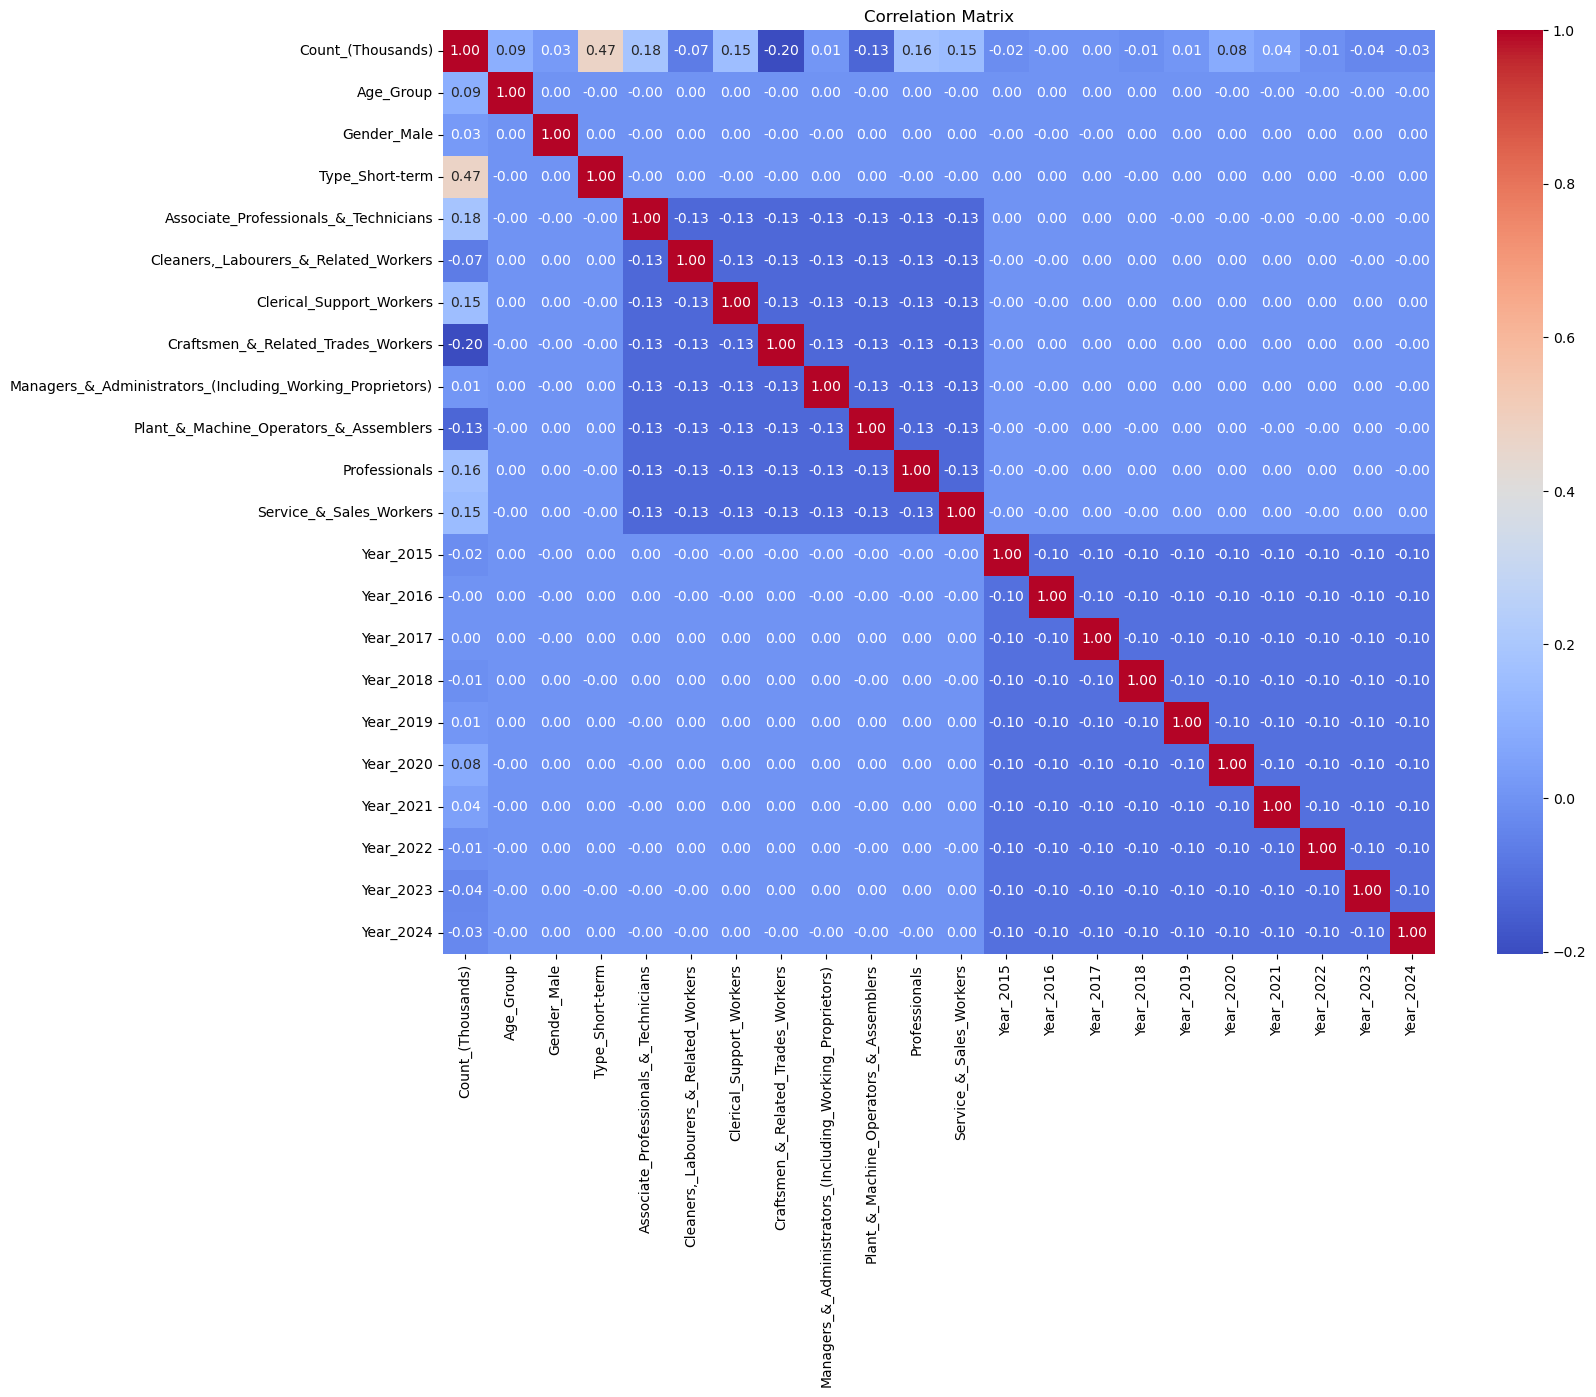

In [10]:
## Check for multicollinearity
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# step 2: VIF
def calculate_vif(df):
    # Add constant (intercept) column for statsmodels
    X = add_constant(df)
    
    # Calculate VIF for each column
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop the constant (intercept) row, since its VIF is not useful
    vif = vif[vif["Variable"] != "const"].reset_index(drop=True)
    return vif

vif_df = calculate_vif(df_encoded.drop('Count_(Thousands)',axis=1))
print(vif_df)
## Since highest VIF is ~1.8, model predictors are reasonably independent and multicollinearity is not a serious concern here.

# step 3: correlation matrix
corr_matrix = df_encoded.corr(numeric_only=True)  
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

### Checking for heteroskedasticity  
if yes, use model = sm.OLS(y, X).fit(cov_type='HC3')  
if homo, use model = sm.OLS(y, X).fit()

In [11]:
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

def check_heteroskedasticity (df, y_label):
    # model is the fitted OLS regression from statsmodels
    X = sm.add_constant(df.drop(y_label, axis=1))
    model = sm.OLS(df[y_label], X ).fit()
    residuals = model.resid

    # White test
    exog = model.model.exog

    white_test = het_white(residuals, exog)
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
    print(dict(zip(labels, white_test)))

def residual_analysis(df, y_label):
    # model is the fitted OLS regression from statsmodels
    X = sm.add_constant(df.drop(y_label, axis=1))
    model = sm.OLS(df[y_label], X ).fit()
    residuals = model.resid

    fitted = model.fittedvalues

    plt.scatter(fitted, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Fitted")
    plt.show()

    return residuals


In [12]:
check_heteroskedasticity (df_encoded, 'Count_(Thousands)')

# If the p-values are very small (< 0.05), reject the null hypothesis of homoskedasticity, implying heteroskedasticity is present.
# This means there is strong statistical evidence of heteroskedasticity in your regression model.

{'Test Statistic': 557.536183482608, 'Test Statistic p-value': 1.0587489955478243e-45, 'F-Statistic': 4.8645455912357765, 'F-Test p-value': 1.272787081050322e-60}


### Residual Analysis

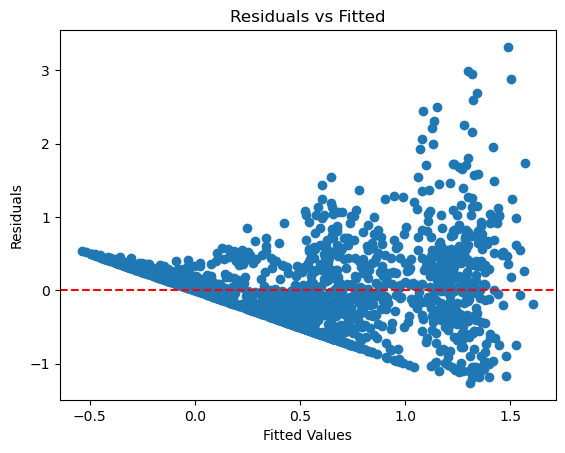

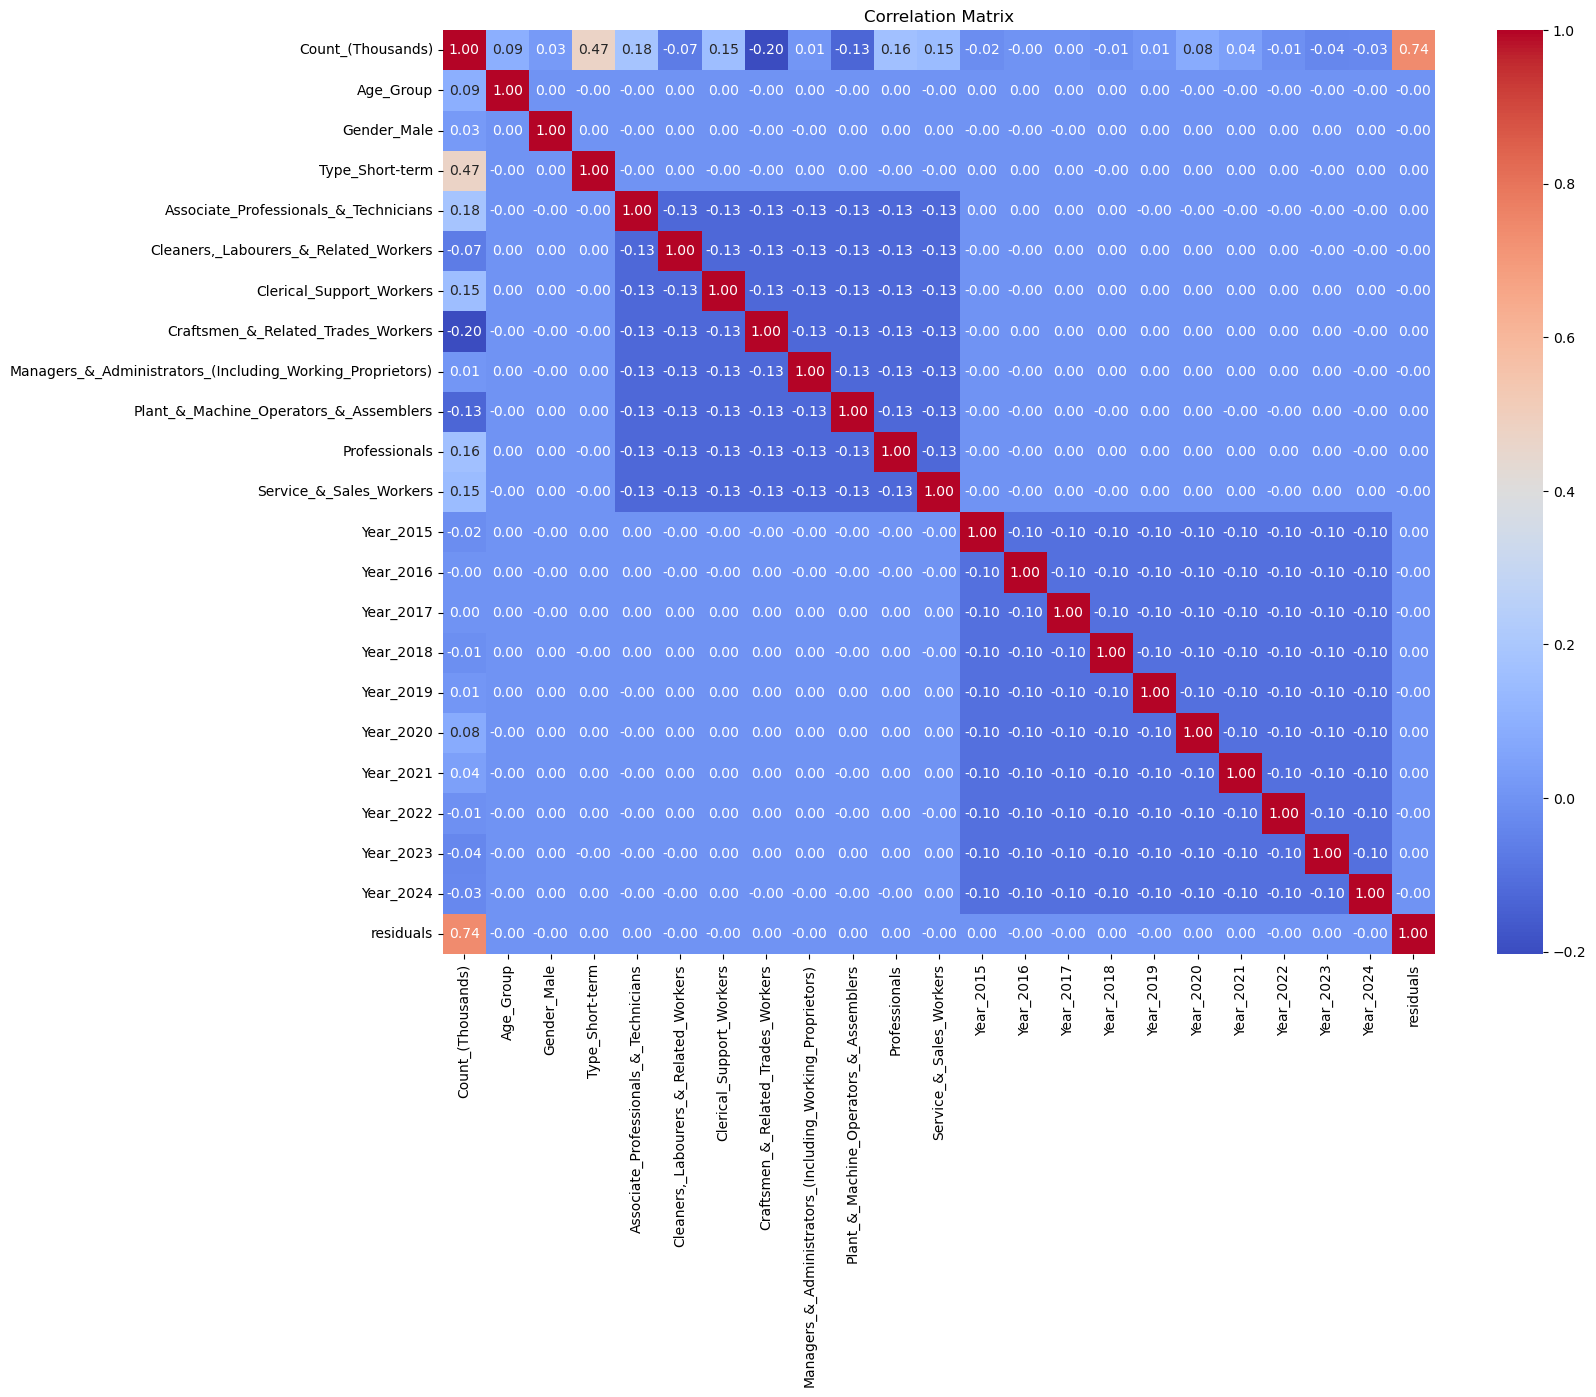

In [13]:
residuals = residual_analysis(df_encoded, 'Count_(Thousands)')
df_residual = df_encoded.copy()
df_residual['residuals'] = residuals
df_residual.head(3)

corr_matrix = df_residual.corr(numeric_only=True)  
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

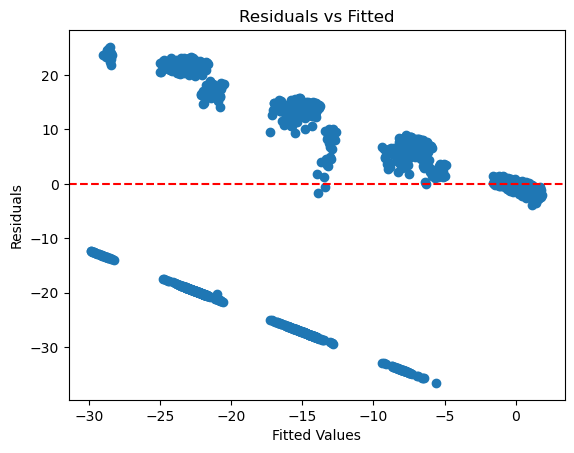

,Count_(Thousands),Age_Group,Gender_Male,Type_Short-term,Associate_Professionals_&_Technicians,"Cleaners,_Labourers_&_Related_Workers",Clerical_Support_Workers,Craftsmen_&_Related_Trades_Workers,Managers_&_Administrators_(Including_Working_Proprietors),Plant_&_Machine_Operators_&_Assemblers,...,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024,residuals
0,-1.250490,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12.983278
1,0.275814,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.106323
2,-42.257337,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-20.276838


In [14]:
# Since the shape is funnel-shaped residual plot, log-transform the dependent variable

df_encoded_logY = df_encoded.copy()
min_positive = df_encoded_logY.loc[df_encoded_logY['Count_(Thousands)'] > 0, 'Count_(Thousands)'].min()
df_encoded_logY['Count_(Thousands)'] = np.log(df_encoded_logY['Count_(Thousands)'] + min_positive / 2)
df_encoded_logY.head(3)

residuals = residual_analysis(df_encoded_logY, 'Count_(Thousands)')
df_residual = df_encoded_logY.copy()
df_residual['residuals'] = residuals
df_residual.head(3)

In [15]:
df_residual[df_residual['residuals'] > 20].nunique()

list = df_residual[df_residual['residuals'] > 20].nunique()
for i,value in enumerate(list):
    if value ==1:
        print(list.index[i] , value)

# so male and short-term

Gender_Male 1
Type_Short-term 1


In [16]:
list = df_residual[(df_residual['residuals'] > -15) & (df_residual['residuals'] < -11)].nunique()
for i,value in enumerate(list):
    if value ==1:
        print(list.index[i] , value)

Count_(Thousands) 1
Gender_Male 1
Type_Short-term 1
Associate_Professionals_&_Technicians 1
Cleaners,_Labourers_&_Related_Workers 1
Clerical_Support_Workers 1
Craftsmen_&_Related_Trades_Workers 1
Managers_&_Administrators_(Including_Working_Proprietors) 1
Plant_&_Machine_Operators_&_Assemblers 1
Professionals 1
Service_&_Sales_Workers 1
Year_2024 1


In [17]:
list = df_residual[(df_residual['residuals'] < -30)].nunique()
for i,value in enumerate(list):
    if value ==1:
        print(list.index[i] , value)

df_residual[(df_residual['residuals'] < -30)].head()
# this Count_(Thousands) is the addition during log transformation

Count_(Thousands) 1
Type_Short-term 1
Associate_Professionals_&_Technicians 1
Cleaners,_Labourers_&_Related_Workers 1
Clerical_Support_Workers 1
Professionals 1
Service_&_Sales_Workers 1


,Count_(Thousands),Age_Group,Gender_Male,Type_Short-term,Associate_Professionals_&_Technicians,"Cleaners,_Labourers_&_Related_Workers",Clerical_Support_Workers,Craftsmen_&_Related_Trades_Workers,Managers_&_Administrators_(Including_Working_Proprietors),Plant_&_Machine_Operators_&_Assemblers,...,Year_2016,Year_2017,Year_2018,Year_2019,Year_2020,Year_2021,Year_2022,Year_2023,Year_2024,residuals
223,-42.257337,2,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-35.304647
239,-42.257337,2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-33.845958
259,-42.257337,3,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-35.394666
275,-42.257337,3,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-33.935977
283,-42.257337,3,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,-34.413168


In [18]:
for i,value in enumerate(df_residual.nunique()):
    if value ==1:
        print(list.index[i] , value)

In [19]:
### Add in interactive dummy variables.

from itertools import product

# print(df_encoded_logY.columns)
# print(df['Occupation'].unique())
occup_list = [e for e in df['Occupation'].str.replace(' ', '_').unique() if e != 'Others']
binary_vars_list = ['Gender_Male', 'Type_Short-term']

df_encoded_logY_interactiveDummies = df_encoded_logY.copy()
for occ, binary in product(occup_list, binary_vars_list):
    # New column name to reflect the interaction term
    new_col_name = f"{occ}_x_{binary}"
    # Create interaction dummy by element-wise multiplication
    df_encoded_logY_interactiveDummies[new_col_name] = df_encoded_logY[occ] * df_encoded_logY[binary]

df_encoded_logY_interactiveDummies.info()

pooled_linear_regression_heteroskedasticity(df_encoded_logY_interactiveDummies, 'Count_(Thousands)')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 38 columns):
 #   Column                                                                       Non-Null Count  Dtype  
---  ------                                                                       --------------  -----  
 0   Count_(Thousands)                                                            1584 non-null   float64
 1   Age_Group                                                                    1584 non-null   int64  
 2   Gender_Male                                                                  1584 non-null   int32  
 3   Type_Short-term                                                              1584 non-null   int32  
 4   Associate_Professionals_&_Technicians                                        1584 non-null   int32  
 5   Cleaners,_Labourers_&_Related_Workers                                        1584 non-null   int32  
 6   Clerical_Support_Workers                

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Count_(Thousands)   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     27.56
Date:                Fri, 12 Sep 2025   Prob (F-statistic):          2.51e-142
Time:                        23:21:20   Log-Likelihood:                -6544.7
No. Observations:                1584   AIC:                         1.317e+04
Df Residuals:                    1546   BIC:                         1.337e+04
Df Model:                          37                                         
Covariance Type:                  HC3                                         
===============================================================================================================================================
                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
const                                                                         -29.6961      2.577    -11.523      0.000     -34.747     -24.645
Age_Group                                                                       0.0900      0.350      0.257      0.797      -0.596       0.776
Gender_Male                                                                    14.6212      2.358      6.200      0.000       9.999      19.243
Type_Short-term                                                                10.6768      2.358      4.527      0.000       6.055      15.299
Associate_Professionals_&_Technicians                                           3.4115      3.236      1.054      0.292      -2.932       9.755
Cleaners,_Labourers_&_Related_Workers                                           9.2122      3.334      2.763      0.006       2.677      15.748
Clerical_Support_Workers                                                        3.6350      3.243      1.121      0.262      -2.722       9.992
Craftsmen_&_Related_Trades_Workers                                             11.6323      3.249      3.580      0.000       5.264      18.000
Managers_&_Administrators_(Including_Working_Proprietors)                       6.7400      3.408      1.978      0.048       0.061      13.419
Plant_&_Machine_Operators_&_Assemblers                                         16.0447      2.978      5.388      0.000      10.208      21.881
Professionals                                                                   2.9144      3.197      0.912      0.362      -3.352       9.181
Service_&_Sales_Workers                                                         4.1612      3.263      1.275      0.202      -2.233      10.556
Year_2015                                                                      -0.3292      1.788     -0.184      0.854      -3.834       3.176
Year_2016                                                                      -1.1020      1.819     -0.606      0.545      -4.668       2.464
Year_2017                                                                      -0.7658      1.759     -0.435      0.663      -4.214       2.682
Year_2018                                                                       0.0006      1.854      0.000      1.000      -3.632       3.634
Year_2019                                                                       0.0765      1.767      0.043      0.965      -3.387       3.540
Year_2020                                                                      -0.2574      1.818     -0.142      0.887      -3.821       3.306
Year_2021                                                  

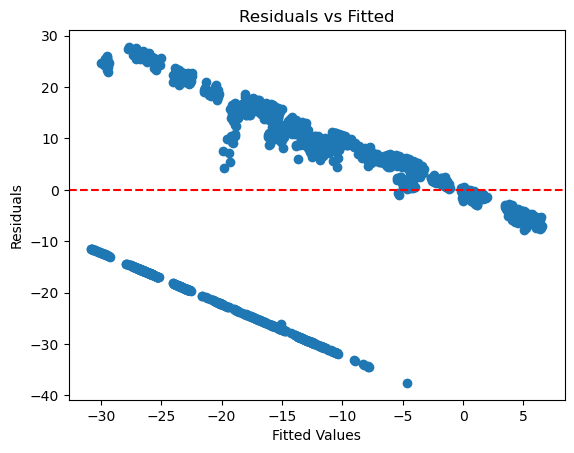

,Count_(Thousands),Age_Group,Gender_Male,Type_Short-term,Associate_Professionals_&_Technicians,"Cleaners,_Labourers_&_Related_Workers",Clerical_Support_Workers,Craftsmen_&_Related_Trades_Workers,Managers_&_Administrators_(Including_Working_Proprietors),Plant_&_Machine_Operators_&_Assemblers,...,"Cleaners,_Labourers_&_Related_Workers_x_Type_Short-term",Clerical_Support_Workers_x_Gender_Male,Clerical_Support_Workers_x_Type_Short-term,Craftsmen_&_Related_Trades_Workers_x_Gender_Male,Craftsmen_&_Related_Trades_Workers_x_Type_Short-term,Plant_&_Machine_Operators_&_Assemblers_x_Gender_Male,Plant_&_Machine_Operators_&_Assemblers_x_Type_Short-term,Service_&_Sales_Workers_x_Gender_Male,Service_&_Sales_Workers_x_Type_Short-term,residuals
0,-1.250490,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14.676147
1,0.275814,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-5.410345
2,-42.257337,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-15.972815


In [20]:
residuals = residual_analysis(df_encoded_logY_interactiveDummies, 'Count_(Thousands)')
df_residual = df_encoded_logY_interactiveDummies.copy()
df_residual['residuals'] = residuals
df_residual.head(3)

In [21]:
list = df_residual[df_residual['residuals']>-10].nunique()
for i,value in enumerate(list):
    if value ==1:
        print(list.index[i] , value)

In [22]:
list = df_residual[df_residual['residuals']<-10].nunique()
for i,value in enumerate(list):
    if value ==1:
        print(list.index[i] , value)

Associate_Professionals_&_Technicians_x_Type_Short-term 1
Professionals_x_Type_Short-term 1
Cleaners,_Labourers_&_Related_Workers_x_Type_Short-term 1
Clerical_Support_Workers_x_Type_Short-term 1
Service_&_Sales_Workers_x_Type_Short-term 1


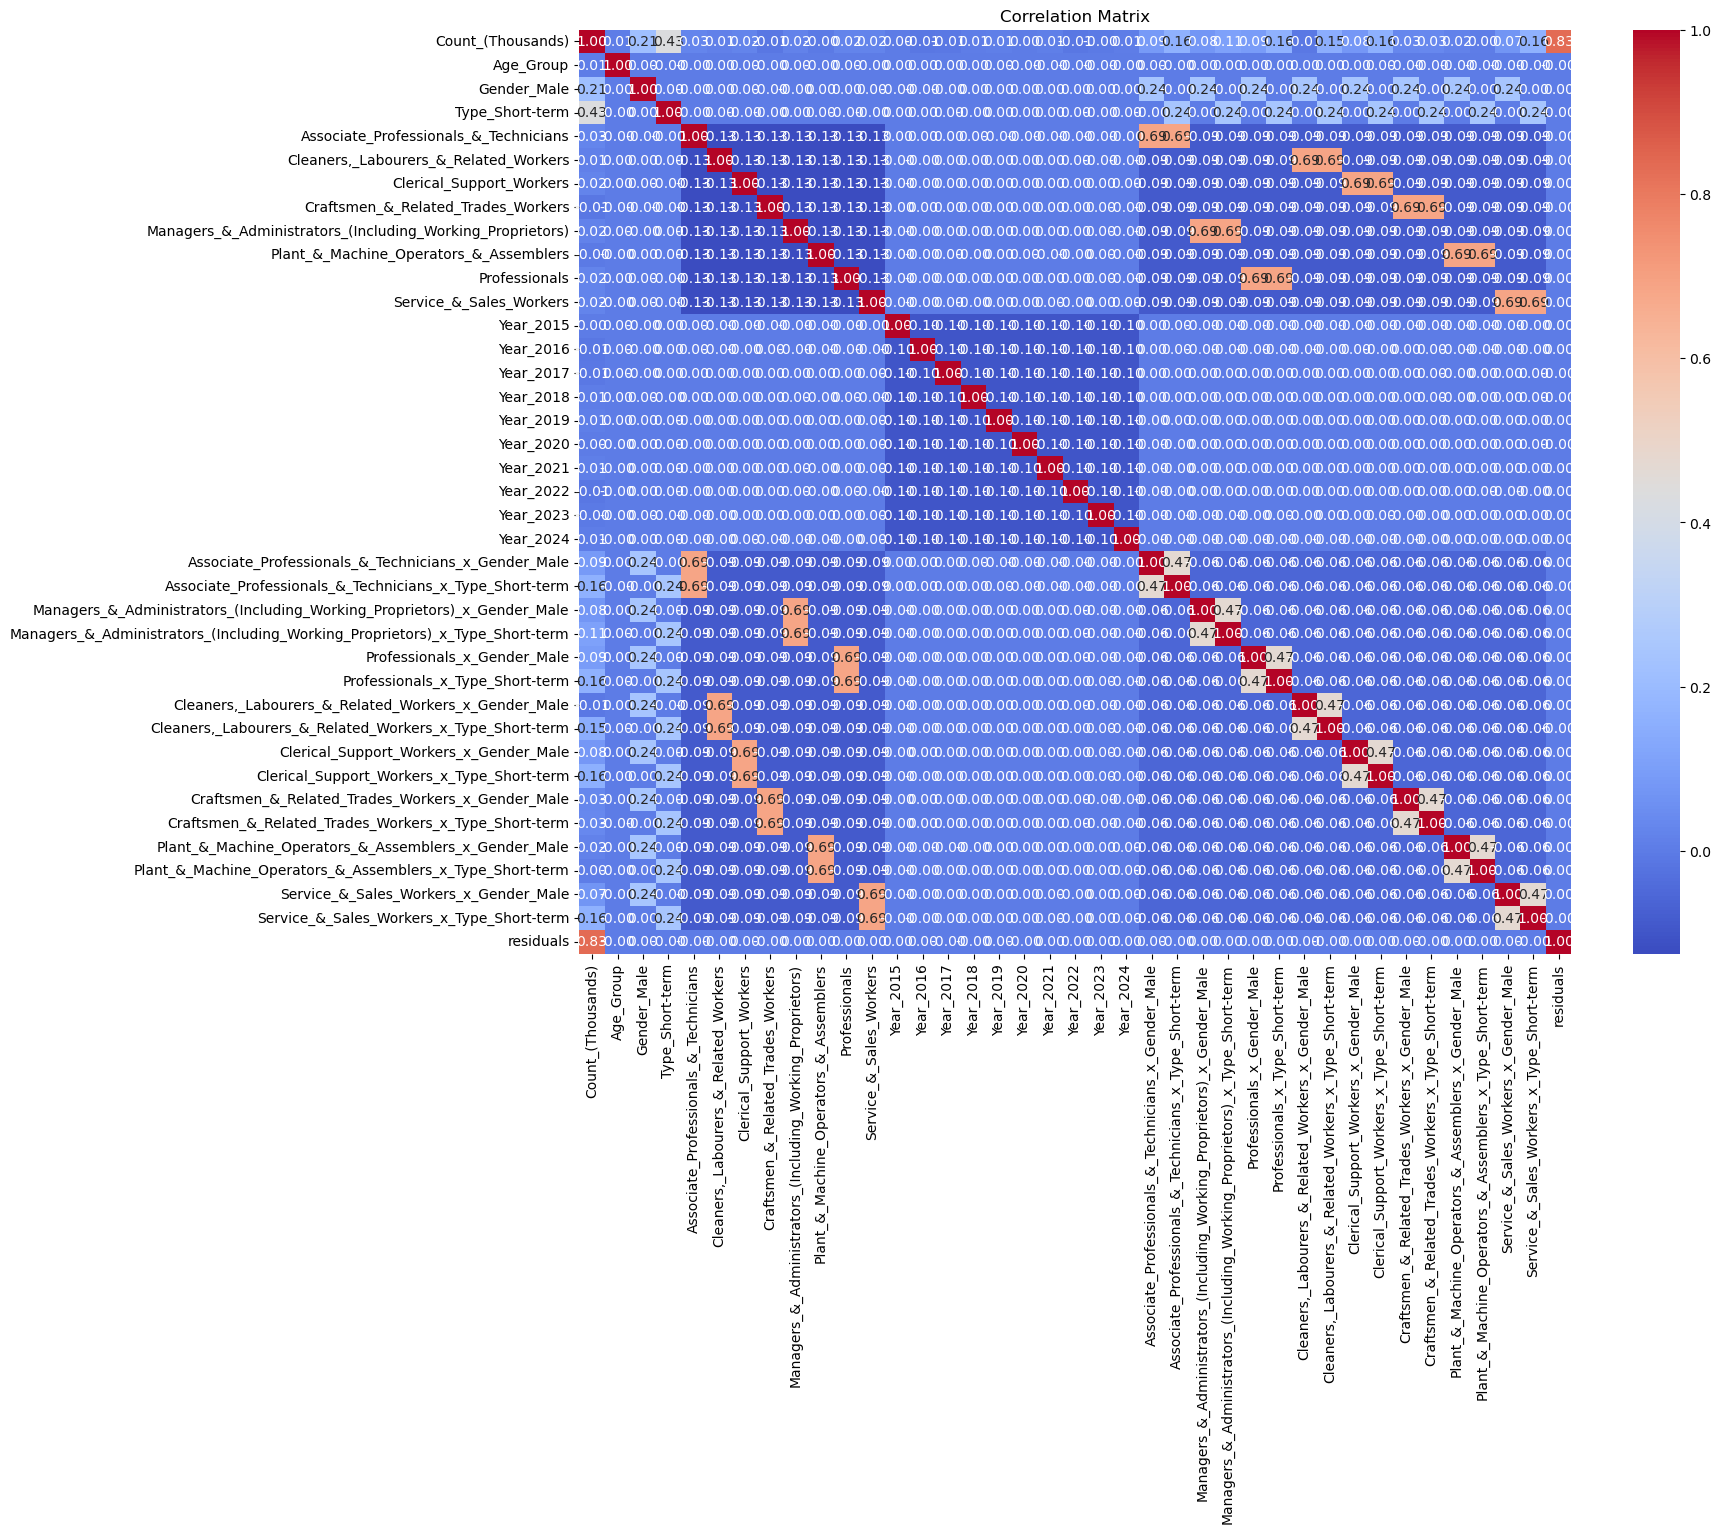

In [23]:
corr_matrix = df_residual.corr(numeric_only=True)  
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
### Keep only the significant interaction terms and simplify the model. Possibly use regularization or selection techniques.

### Multilevel (Hierarchical) Models account for (Year-Level Deviations) using smf.mixedlm lib

### Add in GDP if above failed

Patterned Residuals: The residuals still show some structure—grouping and curvature—rather than being randomly scattered around zero. This suggests that while heteroskedasticity may be mitigated, model misspecification could still be present.

Non-linearity: The residuals seem to curve, which may indicate that the relationship between predictors and the log-transformed target isn't fully linear.

Suggestions to Further Improve Model Fit
1. Add Polynomial or Interaction Terms  
If you suspect non-linear relationships:

python
df_encoded['AgeGroup_squared'] = df_encoded['AgeGroup'] ** 2
Or explore interactions:

python
df_encoded['Year_2020_x_AgeGroup'] = df_encoded['Year_2020'] * df_encoded['AgeGroup']  

2. Try Partial Residual Plots  
These help visualize the effect of each predictor while controlling for others.

3. Consider Generalized Additive Models (GAMs)  
If linearity is too restrictive, GAMs allow flexible smoothing:

python
from pygam import LinearGAM, s
gam = LinearGAM(s(0) + s(1) + ...).fit(X, y)  

4. Check for Influential Observations  
Use Cook’s distance or leverage plots to identify points that disproportionately affect the model.

In [21]:


# F-test method to test if significance - covid and then split it up...



Plot :  
x-axis as year since 2020 and 2021 are significant and high beta  
y-axis as count  
hue as occupations  
split as long-term/short-term  

Instead of splitting into long-term,short-term, add in interactive dummy terms  
to investigate if long-term and short-term diatically change the coefficients.  

#### Option 1: Split and run two separate models
short_term = df[df['Type_Short-term'] == 1]
long_term = df[df['Type_Short-term'] == 0]

model_short = sm.OLS(short_term['y'], sm.add_constant(short_term[predictors])).fit()
model_long = sm.OLS(long_term['y'], sm.add_constant(long_term[predictors])).fit()

#### Option 2: Keep one model but add interactions
formula = 'y ~ Age_Group * Type_Short_term + Gender_Male * Type_Short_term + ...'
model_interact = smf.ols(formula, data=df).fit()

If the interaction coefficient is small and statistically insignificant, it means:
The slope for Age_Group in short-term contracts is not meaningfully different from the slope in long-term contracts.
In other words, the effect of Age_Group is essentially the same across both groups, so there’s no evidence that contract type drastically changes that relationship.

Check significance of each interaction term.
If none are significant → keep the simpler pooled model (no interactions).
If some are significant → keep them, or consider splitting the model if the differences are large and theory supports it.

eg y = β0 + β1*Age_Group + β2*Type_Short_term + β3*(Age_Group * Type_Short_term) + ...
If you want, I can show you how to test all interaction terms at once with an F-test, so you can formally decide whether short-term vs. long-term changes any coefficients before you even think about splitting the model.



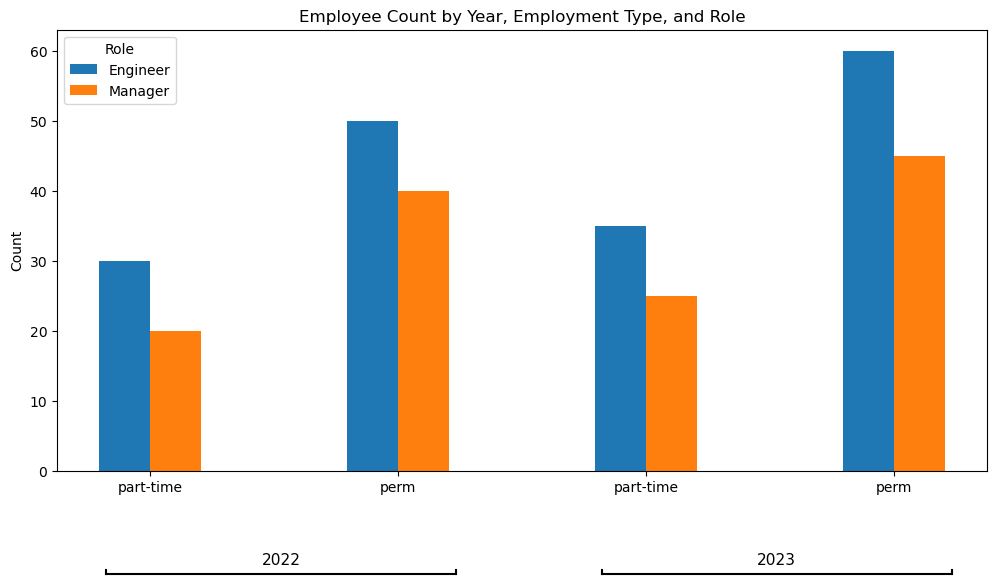

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Sample data
data = pd.DataFrame({
    'year': [2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023],
    'employment_type': ['part-time', 'perm', 'part-time', 'perm'] * 2,
    'role': ['Engineer', 'Engineer', 'Manager', 'Manager'] * 2,
    'count': [30, 50, 20, 40, 35, 60, 25, 45]
})

# Pivot
pivot = data.pivot_table(index='role', columns=['year', 'employment_type'], values='count')
pivot = pivot.sort_index(axis=1, level=[0, 1])

roles = pivot.index.tolist()
groups = pivot.columns.tolist()
n_roles = len(roles)
n_groups = len(groups)

bar_width = 0.35
group_spacing = 1.0
x = np.arange(n_groups) * (n_roles * bar_width + group_spacing)

# Create main figure and axes
fig, ax = plt.subplots(figsize=(12, 7))

# Bar plot
for i, role in enumerate(roles):
    counts = pivot.loc[role].values
    bar_positions = x + i * bar_width
    ax.bar(bar_positions, counts, width=bar_width, label=role)

# Main x-ticks (employment_type)
xtick_labels = [etype for (_, etype) in groups]
xtick_positions = x + bar_width * (n_roles - 1) / 2
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# Style
ax.set_ylabel("Count")
ax.set_title("Employee Count by Year, Employment Type, and Role")
ax.legend(title="Role")
ax.set_ylim(bottom=0)

# -----------------------------------------
# Bracket BELOW the plot using inset_axes
# -----------------------------------------
bracket_ax = inset_axes(ax,
                        width="100%", height="10%",  # full width, short height
                        bbox_to_anchor=(0, -0.25, 1, 0.1),  # fully outside
                        bbox_transform=ax.transAxes,
                        loc='lower left')

bracket_ax.axis("off")

years = sorted(set([year for (year, _) in groups]))

for year in years:
    year_indices = [i for i, (y, _) in enumerate(groups) if y == year]
    left = xtick_positions[year_indices[0]] - bar_width
    right = xtick_positions[year_indices[-1]] + bar_width

    bracket_y = 0.1
    tick_height = 0.1
    text_y = bracket_y + 0.15

    # Horizontal line
    bracket_ax.plot([left, right], [bracket_y, bracket_y], color='black', lw=1.5, clip_on=False)
    # Vertical ticks (pointing up)
    bracket_ax.plot([left, left], [bracket_y, bracket_y + tick_height], color='black', lw=1.5, clip_on=False)
    bracket_ax.plot([right, right], [bracket_y, bracket_y + tick_height], color='black', lw=1.5, clip_on=False)

    # Year label ABOVE bracket
    bracket_ax.text((left + right)/2, text_y, str(year),
                    ha='center', va='bottom', fontsize=11, clip_on=False)

# Prevent clipping
fig.subplots_adjust(bottom=0.25)
plt.show()


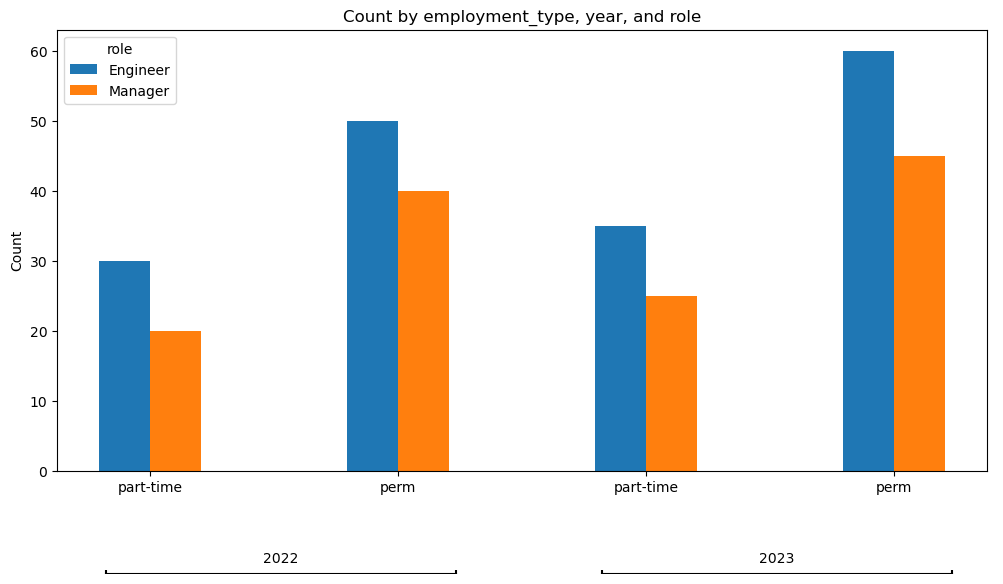

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_grouped_bar(data, year_col, type_col, role_col, count_col):
    # Sort and prepare data
    data_sorted = data.sort_values([year_col, type_col, role_col])
    roles = data_sorted[role_col].unique()
    groups = data_sorted[[year_col, type_col]].drop_duplicates().values.tolist()

    # X positions
    bar_width = 0.35
    group_spacing = 1.0
    n_roles = len(roles)
    x = np.arange(len(groups)) * (n_roles * bar_width + group_spacing)
    xtick_positions = x + bar_width * (n_roles - 1) / 2

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot bars
    for i, role in enumerate(roles):
        values = []
        for year, etype in groups:
            count = data_sorted.query(
                f"{year_col}=={year} and {type_col}=='{etype}' and {role_col}=='{role}'"
            )[count_col].values
            values.append(count[0] if len(count) > 0 else 0)
        ax.bar(x + i * bar_width, values, width=bar_width, label=role)

    # X-axis labels
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([etype for _, etype in groups])
    ax.set_ylabel(count_col.capitalize())
    ax.set_title(f"{count_col.capitalize()} by {type_col}, {year_col}, and {role_col}")
    ax.legend(title=role_col)

    # Add brackets below using inset axes
    bracket_ax = inset_axes(ax, width="100%", height="10%",
                            bbox_to_anchor=(0, -0.25, 1, 0.1),
                            bbox_transform=ax.transAxes, loc='lower left')
    bracket_ax.axis("off")

    # Draw brackets and year labels
    years = sorted(set(data[year_col]))
    for year in years:
        year_indices = [i for i, (y, _) in enumerate(groups) if y == year]
        left = xtick_positions[year_indices[0]] - bar_width
        right = xtick_positions[year_indices[-1]] + bar_width
        bracket_y = 0.5
        tick_h = 0.1
        label_y = bracket_y + 0.2

        bracket_ax.plot([left, right], [bracket_y]*2, color='black', lw=1.5)
        bracket_ax.plot([left, left], [bracket_y, bracket_y + tick_h], color='black', lw=1.5)
        bracket_ax.plot([right, right], [bracket_y, bracket_y + tick_h], color='black', lw=1.5)
        bracket_ax.text((left + right)/2, label_y, str(year), ha='center', va='bottom')

    fig.subplots_adjust(bottom=0.25)
    plt.show()

# Example usage
df = pd.DataFrame({
    'year': [2022]*4 + [2023]*4,
    'employment_type': ['part-time', 'perm']*4,
    'role': ['Engineer', 'Engineer', 'Manager', 'Manager']*2,
    'count': [30, 50, 20, 40, 35, 60, 25, 45]
})

plot_grouped_bar(df, 'year', 'employment_type', 'role', 'count')


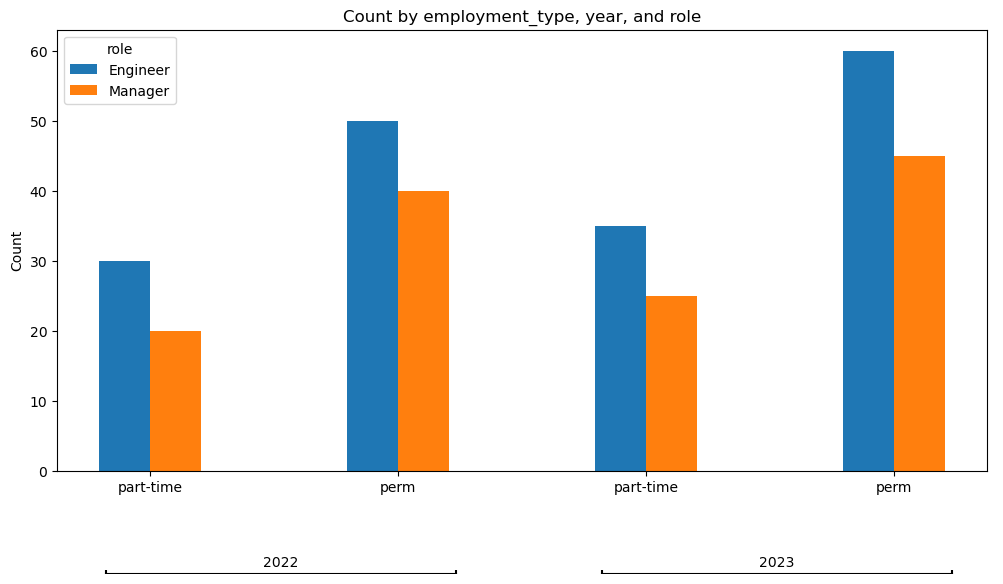

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_grouped_bar(data, year_col, type_col, role_col, count_col):
    # Sort and prepare data
    data_sorted = data.sort_values([year_col, type_col, role_col])
    roles = data_sorted[role_col].unique()
    groups = data_sorted[[year_col, type_col]].drop_duplicates().values.tolist()

    # X positions
    bar_width = 0.35
    group_spacing = 1.0
    n_roles = len(roles)
    x = np.arange(len(groups)) * (n_roles * bar_width + group_spacing)
    xtick_positions = x + bar_width * (n_roles - 1) / 2

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot bars
    for i, role in enumerate(roles):
        values = []
        for year, etype in groups:
            count = data_sorted.query(
                f"{year_col}=={year} and {type_col}=='{etype}' and {role_col}=='{role}'"
            )[count_col].values
            values.append(count[0] if len(count) > 0 else 0)
        ax.bar(x + i * bar_width, values, width=bar_width, label=role)

    # X-axis labels
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels([etype for _, etype in groups])
    ax.set_ylabel(count_col.capitalize())
    ax.set_title(f"{count_col.capitalize()} by {type_col}, {year_col}, and {role_col}")
    ax.legend(title=role_col)

    # Add brackets below using inset axes
    bracket_ax = inset_axes(ax, width="100%", height="10%",
                            bbox_to_anchor=(0, -0.25, 1, 0.1),
                            bbox_transform=ax.transAxes, loc='lower left')
    bracket_ax.axis("off")

    # Draw brackets and year labels
    years = sorted(set(data[year_col]))
    for year in years:
        year_indices = [i for i, (y, _) in enumerate(groups) if y == year]
        left = xtick_positions[year_indices[0]] - bar_width
        right = xtick_positions[year_indices[-1]] + bar_width
        bracket_y = 0.8 
        tick_h = 0.1
        label_y = bracket_y + 0.1   

        bracket_ax.plot([left, right], [bracket_y]*2, color='black', lw=1.5)
        bracket_ax.plot([left, left], [bracket_y, bracket_y + tick_h], color='black', lw=1.5)
        bracket_ax.plot([right, right], [bracket_y, bracket_y + tick_h], color='black', lw=1.5)
        bracket_ax.text((left + right)/2, label_y, str(year), ha='center', va='bottom')

    fig.subplots_adjust(bottom=0.25)
    plt.show()

# Example usage
df = pd.DataFrame({
    'year': [2022]*4 + [2023]*4,
    'employment_type': ['part-time', 'perm']*4,
    'role': ['Engineer', 'Engineer', 'Manager', 'Manager']*2,
    'count': [30, 50, 20, 40, 35, 60, 25, 45]
})

plot_grouped_bar(df, 'year', 'employment_type', 'role', 'count')


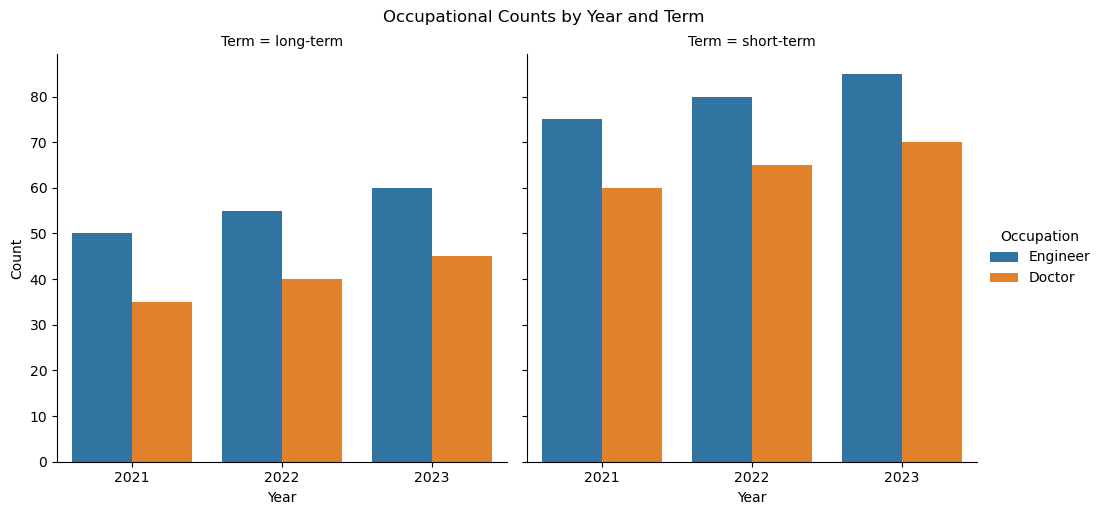

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Data
data = {
    'Year': [2021, 2021, 2021, 2021, 2022, 2022, 2022, 2022, 2023, 2023, 2023, 2023],
    'Term': ['long-term', 'long-term', 'short-term', 'short-term', 'long-term', 'long-term', 'short-term', 'short-term', 'long-term', 'long-term', 'short-term', 'short-term'],
    'Occupation': ['Engineer', 'Doctor', 'Engineer', 'Doctor', 'Engineer', 'Doctor', 'Engineer', 'Doctor', 'Engineer', 'Doctor', 'Engineer', 'Doctor'],
    'Count': [50, 35, 75, 60, 55, 40, 80, 65, 60, 45, 85, 70]
}
df = pd.DataFrame(data)

# Create the plot
sns.catplot(
    data=df,
    x='Year',
    y='Count',
    hue='Occupation',
    col='Term',
    kind='bar'
)

# Add a title and show the plot
plt.suptitle('Occupational Counts by Year and Term', y=1.02)
plt.show()